In [1]:
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import jit, value_and_grad, grad
import numpy as onp
import torch
import torch.nn as nn

In [2]:
@jit
def compute_potential_point(coord, target_coord):
    return 20 * np.sum((coord - target_coord) ** 2)

@jit
def compute_rolling_friction_force(velocity, mass, radius, f, g=9.8):
    return - np.sign(velocity) * mass * g * radius * f / radius

@jit
def compute_acceleration(potential_force, friction_force, mass):
    return (potential_force + friction_force) / mass

@jit
def get_new_cv(current_coordinate, current_velocity, acceleration, dt):
    new_velocity = current_velocity + acceleration * dt
    new_coordinate = current_coordinate + new_velocity * dt
    return new_coordinate, new_velocity

@jit
def run_sim(coordinate_init, velocity_init, target_coordinate, constants):
    trajectory = []
    sim_time = 0.2
    n_steps = 20
    dt = sim_time / n_steps
    coordinate = coordinate_init
    velocity = velocity_init
    for t in np.linspace(0, sim_time, n_steps):
        trajectory.append(coordinate)
        l2_force = - grad(compute_potential_point)(coordinate, target_coordinate)
        friction_force = compute_rolling_friction_force(velocity,
                                                        constants['mass'],
                                                        constants['radius'],
                                                        constants['f'])
        acceleration = compute_acceleration(l2_force,
                                            friction_force,
                                            constants['mass'])
        coordinate, velocity = get_new_cv(coordinate, velocity, acceleration, dt)
    return coordinate, trajectory

@jit
def compute_loss(coordinate_init, velocity_init, target_coordinate, attractor, constants):
    final_coord, _ = run_sim(coordinate_init, velocity_init, attractor, constants)
    return np.sum(np.abs(final_coord - target_coordinate))


In [3]:
constants = {}
constants['radius'] = 0.05
constants['ro'] = 1000.
constants['volume'] = 4 * np.pi * (constants['radius'] ** 3) / 3
constants['mass'] = constants['volume'] * constants['ro']
constants['f'] = 0.007

target_coordinate = np.array([0.5, 0.5])
coordinate_init = np.array([0.2, 0.4])
velocity_init = np.array([1., 0.])
attractor = np.array([0., 0.])

#%time trajectory = run_sim(coordinate_init, velocity_init, coordinate_target, sim_time, n_steps)

In [4]:
class Controller(nn.Module):
    def __init__(self):
        super().__init__()
        self.controller = nn.Sequential(nn.Linear(5, 20),
                                        nn.ReLU(),
                                        nn.Linear(20, 50),
                                        nn.ReLU(),
                                        nn.Linear(50, 2))
    
    def forward(self, x):
        return self.controller(x)

In [5]:
ctrl = Controller()

In [62]:
from time import time
opt = torch.optim.Adam(ctrl.parameters())
velocity_init = np.array([1., 0.])
for step in range(10):
    s = time()
    
    coordinate_init = np.array(onp.random.uniform(-1., 1., size=(2,)))
    dist = onp.linalg.norm(coordinate_init - target_coordinate)
    direction = (coordinate_init - target_coordinate) / dist
    sd = onp.sin(direction)

    net_inp = torch.cat([torch.from_numpy(onp.array(o)).view(1, -1) for o in [direction, sd, dist]], dim=1)
    
    
    controller_out = ctrl(net_inp)
    velocity_init = np.array(controller_out.cpu().data.numpy()[0])
    loss_val, v_grad = value_and_grad(compute_loss, 1)(coordinate_init, velocity_init, target_coordinate, attractor, constants)
    opt.zero_grad()
    controller_out.backward(torch.from_numpy(onp.array(v_grad))[None, :])
    opt.step()
    if step % 5 == 0:
        print(time() - s, loss_val, velocity_init, v_grad)


0.007105588912963867 0.511162 [2.7983727 2.9540153] [-0.11271466 -0.11271466]
0.006380319595336914 0.30887175 [4.487606 4.780789] [0.11271466 0.11271466]


In [63]:
final_coordinate, trajectory = run_sim(coordinate_init, velocity_init, attractor, constants)

In [64]:
traj = np.array(trajectory)

<ipython-input-65-b01971e0e045>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


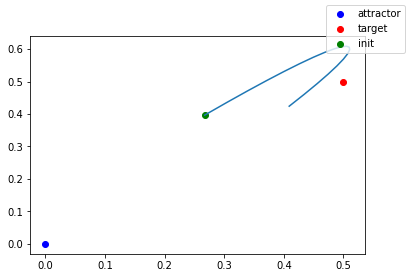

In [65]:
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.plot(traj[:, 0], traj[:, 1])
ax.scatter(attractor[0], attractor[1], c='b', label='attractor')
ax.scatter(target_coordinate[0], target_coordinate[1], c='r', label='target')
ax.scatter(coordinate_init[0], coordinate_init[1], c='g', label='init')
fig.legend()
#ax.set_xlim(-0.5, 0.5)
#ax.set_ylim(-0.5, 0.5)
fig.show()